In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
np.random.seed(0)

In [3]:
#Read data from fie
data = np.genfromtxt("breast-cancer.data", delimiter=",", missing_values="?", filling_values=1.)

#Separate the X
dataX = data[:, 1:-1]
#Separate the Y
pre_dataY = data[:, -1]
#Convert the Y to one hot
dataY = np.zeros((pre_dataY.size, 2))

for i in range(len(pre_dataY)):
    if pre_dataY[i] == 2:
        dataY[i][0] = 1
    else:
        dataY[i][1] = 1

In [4]:
#Mix up the data
permutation = np.random.permutation(dataX.shape[0])
dataX = dataX[permutation]
dataY = dataY[permutation]

In [5]:
#Set network variables and hyperparameters
nIn = 9
nHidden = 25
nOut = 2
alpha = 0.01
nEpochs = 100
testSplit = 0.15
batchSize = 64

In [6]:
#Create palceholder for X and Y
X = tf.placeholder(shape=[None, nIn], dtype=tf.float32)
Y = tf.placeholder(shape=[None, nOut], dtype=tf.float32)

In [7]:
#Initialize wieghts and biases
weights = {"W1": tf.Variable(tf.random_normal([nIn, nHidden]) * 0.5),
           "W2": tf.Variable(tf.random_normal([nHidden, nOut]) * 0.5)}

biases = {"b1": tf.Variable(tf.zeros([nHidden])),
           "b2": tf.Variable(tf.zeros([nOut]))}

In [8]:
#Forward propogation
def nn_forward(X):
    
    layer2 = tf.nn.bias_add(tf.matmul(X, weights["W1"]), biases["b1"])
    layer2 = tf.nn.sigmoid(layer2)
    
    out = tf.nn.bias_add(tf.matmul(layer2, weights["W2"]), biases["b2"])
    
    return out

In [9]:
#Network prediction
pred = nn_forward(X)
#Loss/Cost
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=Y))
#Backpropagation & Network updates
optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred, axis=1), tf.argmax(Y, axis=1)), tf.float32))

In [10]:
#Number of data points used for testing
num_test = int(testSplit * len(data))

#Split data into train and  test
trainX = dataX[:-num_test]
testX = dataX[-num_test:]

trainY = dataY[:-num_test]
testY = dataY[-num_test:]

Epoch 0 Loss: 0.5961856842041016
	Accuracy: 0.06543210082583957
Epoch 10 Loss: 0.0683237612247467
	Accuracy: 0.9123456915219624
Epoch 20 Loss: 0.028445834293961525
	Accuracy: 0.9382716099421183
Epoch 30 Loss: 0.013900160789489746
	Accuracy: 0.9765432112746768
Epoch 40 Loss: 0.006715820170938969
	Accuracy: 0.9901234573788114
Epoch 50 Loss: 0.004716780968010426
	Accuracy: 1.0
Epoch 60 Loss: 0.0035119764506816864
	Accuracy: 1.0
Epoch 70 Loss: 0.002700752578675747
	Accuracy: 1.0
Epoch 80 Loss: 0.002171762054786086
	Accuracy: 1.0
Epoch 90 Loss: 0.0018527249339967966
	Accuracy: 1.0


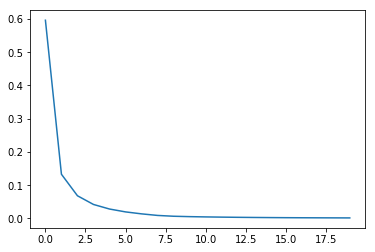

Final Accuracy: 0.9615384936332703


In [11]:
losses = []
displayStride = 10
num_batches = len(trainX)//batchSize

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    correct = 0
    for j in range(nEpochs):
        for i in range(num_batches):
            lowerBound = i * num_batches
            upperBound = min((i+1) * num_batches, len(trainX))
            
            loss, acc, _ = sess.run([cost, accuracy, optimizer], 
                                         feed_dict={X: trainX[lowerBound:upperBound].reshape(-1, nIn), 
                                                    Y: trainY[lowerBound:upperBound].reshape(-1, nOut)})
            correct += acc
        if j % displayStride == 0:
            acc = correct / (displayStride * num_batches)
            print("Epoch {} Loss: {}\n\tAccuracy: {}".format(j, loss, acc))
            correct = 0
        if j % 5 == 0:
            losses.append(loss)

    plt.plot(losses)
    plt.show()

    print("Final Accuracy: {}".format(sess.run(accuracy, feed_dict={X: testX.reshape(-1, nIn), Y: testY.reshape(-1, nOut)})))